# **Алгоритм построения маршрутов для инкассации терминалов**

После того, как мы сформировали файл с терминалами для инкассации, необходимо для каждой машины отобрать нужное количество точек

Хочется дополнить, что в алгоритме можно выбрать болшее количество точек, если позволят вычислительные мощности ПК. 

Моего ПК хватило для расчета маршрута 20 точек

**Идея алгоритма следующая**

1. По выбранной модели отмечаем точки на карте
2. Находим точку центра Москвы
3. Просматриваем все точки и находим расстояние от точки терминала до центра Москвы
4. Находим самую дальнюю точку от Москвы
5. От полученной точки находим самые ближайшие точки для инкассации
6. Формируем матрицу расстояний. (Мой ПК смог обработать матрицу размерности 20х20, далее закончилась оперативная память). Если сделать матрицу большей размерности, то удастся сократить количество бронивиков
7. Для расчета оптимального пути используем Муравьиный алгоритм без возврата в исходную точку
8. Вектор движения направлен от выбранной точки к центру Москвы
9. После отбора точек для построения маршрута, удаляем их из общего списка.
10. Снова находим самую дальную точку от центра Москвы
11. Находим ближайшие точки от выбранной
12. Формируем матрицу расстояний (времени) и поторяем алгоритм до тек пор, пока все точки не попаду в маршрутный лист

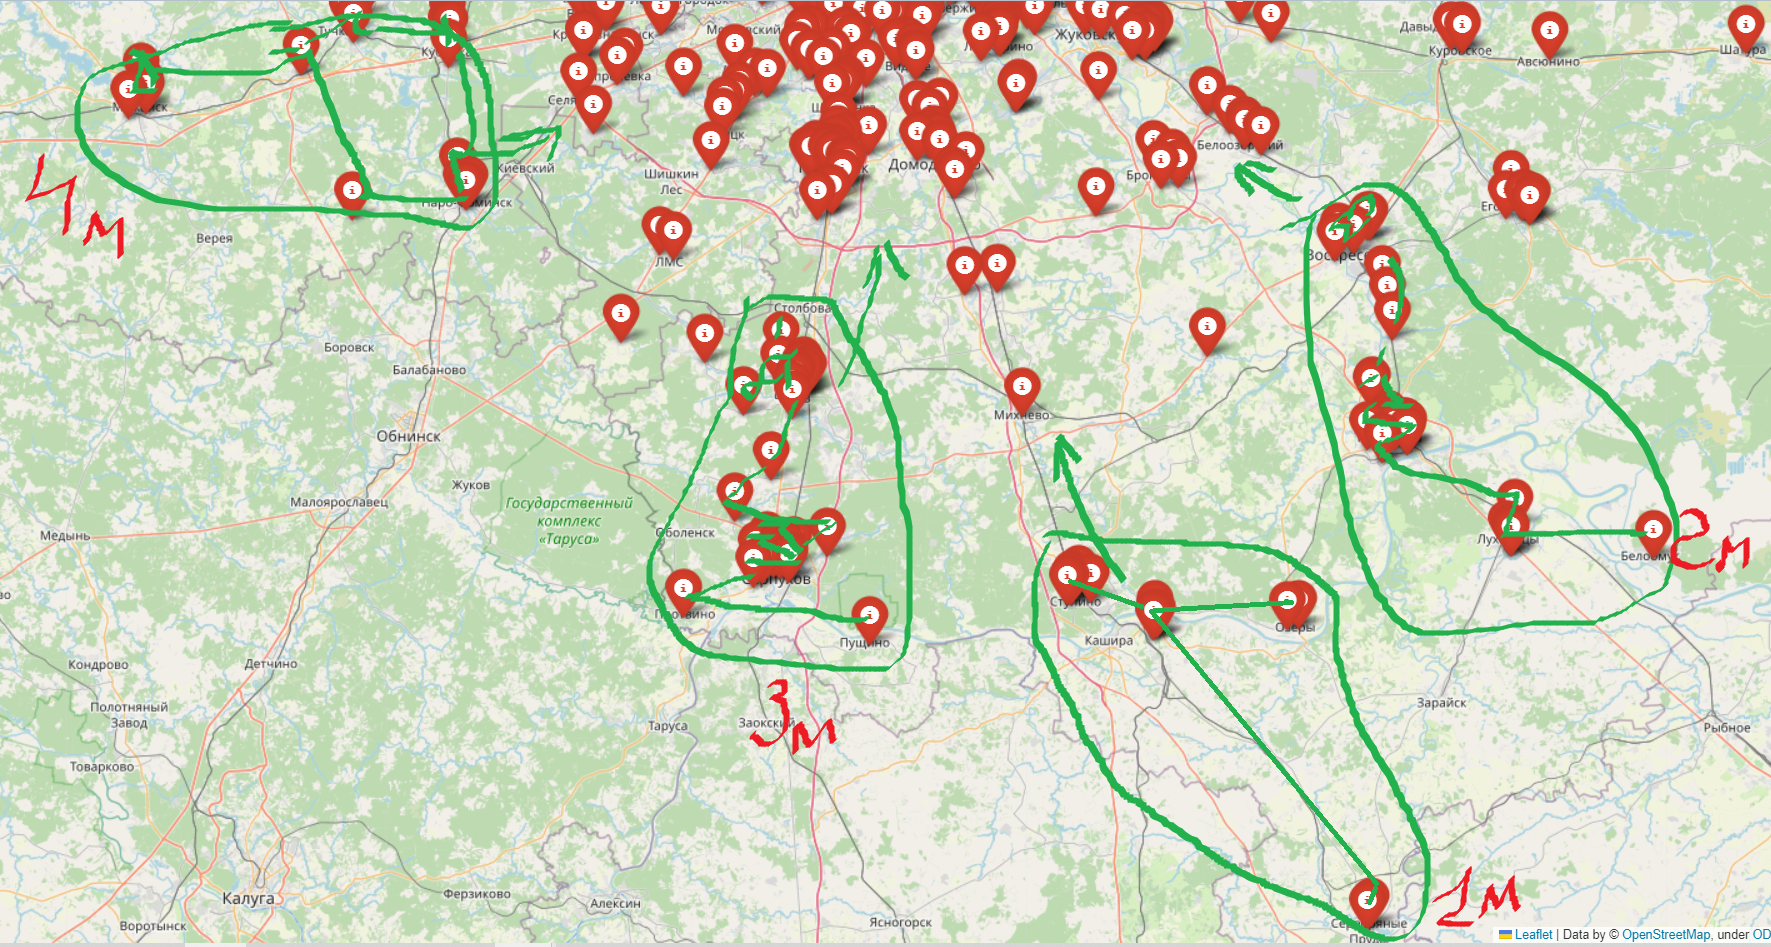

In [38]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import time
import requests
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
from xml.dom import minidom
import datetime as DT
import re
import time
import random
import folium
from python_tsp.exact import solve_tsp_dynamic_programming
from datetime import datetime, timedelta

In [3]:
# Координаты терминалов
atm_cor = pd.read_excel('terminal_data_hackathon v4.xlsx', sheet_name = 'TIDS')
# Подключим библиотеку с данными о времени между точками
times_points = pd.read_csv('times v4.csv')

In [ ]:
# Расчет дистации по прямой от центра Москвы до каждой точки
def distance_1(La1, La2, Lo1, Lo2):
      
    Lo1 = radians(Lo1) 
    Lo2 = radians(Lo2) 
    La1 = radians(La1) 
    La2 = radians(La2) 
       
    D_Lo = Lo2 - Lo1 
    D_La = La2 - La1 
    P = sin(D_La / 2)**2 + cos(La1) * cos(La2) * sin(D_Lo / 2)**2 
  
    Q = 2 * asin(sqrt(P)) 
     
    R_km = 6371 

    return(Q * R_km)

In [168]:
# Центр Москвы
moscow_point = [55.755864, 37.617698]
# Расчет расстояния от центра Москвы до точки
for row in range(0,len(atm_cor)):
    distance = distance_1(moscow_point[0],atm_cor.loc[row,'latitude'],moscow_point[1],atm_cor.loc[row,'longitude'])
    atm_cor.loc[row,'distance_centr'] = distance
# Сортируем список по убыванию
atm_cor = atm_cor.sort_values(by = 'distance_centr', ascending = False).reset_index(drop = True)
atm_cor.head(2)

,TID,longitude,latitude,distance_centr
0,699068,38.726169,54.458423,160.571644
1,634918,38.714527,54.470362,159.049385


In [169]:
# Берем файл с точками для инкассации и добавляем к ним расстояния до центра, предварительно отчищаем его от статуса green
test_point_inc = pd.read_excel('test_point_inc.xlsx')
test_point_inc = test_point_inc.loc[(test_point_inc['Статус']=='red')|(test_point_inc['Статус_1']=='orange')].reset_index(drop = True)
test_point_inc = test_point_inc.merge(atm_cor, on ='TID', how = 'left').sort_values(by = 'distance_centr', ascending = False).reset_index(drop = True)
test_point_inc

,Unnamed: 0,TID,остаток на 31.08.2022 (входящий),Median,День инкассации,Дней без инкассации,Отклонение,Статус,Статус_1,Статус_2,longitude,latitude,distance_centr
0,682,634918,595000,107000,3,6,3,red,NaN,NaN,38.714527,54.470362,159.049385
1,359,619168,406000,51000,4,8,4,red,NaN,NaN,38.723168,54.474093,158.917447
2,944,642873,234000,20000,7,12,5,red,NaN,NaN,39.344439,54.941480,141.832098
3,163,607093,181000,177000,2,1,-1,NaN,orange,NaN,38.889126,54.755324,137.361831
4,403,619644,412000,128000,3,3,0,red,NaN,NaN,35.503646,56.021812,135.098608
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,1546,698654,410000,133000,3,3,0,red,NaN,NaN,37.629623,55.741645,1.748397
1160,875,637187,185000,165000,2,1,-1,NaN,orange,NaN,37.637879,55.764683,1.598704
1161,1624,699577,375000,225000,2,2,0,red,NaN,NaN,37.639246,55.760311,1.436045
1162,1137,659671,269000,72000,4,4,0,red,NaN,NaN,37.599509,55.752411,1.201181


**Цикл формирования матрицы инкассации**

In [170]:
term = 16 # Количество точек для инкассации (итого терм + 1)
num = 0
control = True
colmn = ['TID', 'Последовательность инкассации', 'longitude', 'latitude','distance_centr', 'full_cor','Номер машины']
reports = pd.DataFrame(columns = colmn)
while control:
    if len(test_point_inc) == 0:
        control = False
        break

    # Вторая итерация
    if num >= 1:
        test_point_inc = test_point_inc.loc[~test_point_inc['TID'].isin(inc_term_day['TID'].values)].\
        sort_values(by = 'distance_centr', ascending = False).reset_index(drop = True)
    # Берем первую точку, далее смотрим term ближайших точек от данной точки и создаем матрицу смежности
    # Здесь мы берем первую точку, которая находится дальше всего от центра Москвы. Далее, делаем, чтобы в выборку попали только
    # те терминалы, которые необходимо инкассировать
    if len(test_point_inc) == 0:
        control = False
        break # выход из цикла, если длина массива = 0
    
    tid_1 = test_point_inc.loc[0,'TID']
    points_inc = times_points.loc[(times_points['Origin_tid']==tid_1)&(times_points['Destination_tid']).\
                                  isin(test_point_inc['TID'])].sort_values(by = 'Total_Time').reset_index(drop = True)    
    # Переведем 12 часов в минуты (максимальное время работы в минутах)
    lim_time = 12*60
    # Создадим стисок из треминалов для инкассации
    #Стартовая точка терминалов. Выбираем количество терминалов 20. Так как при большем количестве точек, у меня не хватает оперативаной
    # памяти для обработки данного алгоритма. Требуются большие вычислительные мощности
    
    columns = ['TID',points_inc.loc[0,'Origin_tid']]
    if len(points_inc) < term:
        term = len(points_inc)
    for row in range(0,term):
        columns.append(points_inc.loc[row,'Destination_tid'])
    # Создаем матрицу смежности (времени между точками)
    matrix_df = pd.DataFrame(columns = columns)
    matrix_df.iloc[:,0] = columns[1:]
    #Создаем матрицу для расчета оптимального пути
    i = 0
    k = 0
    for i in range(0,len(matrix_df)):
        ttd = matrix_df.loc[i,'TID']
        #print(ttd)
        for k in range(0,len(matrix_df.columns)):
            j = k+1
            if j == len(matrix_df.columns):
                break
            else:
                # Если значения массива равно 0 выходим из цикла
                if len(times_points.loc[(times_points['Origin_tid'] == ttd)&\
                    (times_points['Destination_tid'] == matrix_df.columns[j]),'Total_Time']) == 0:
                    matrix_df.loc[i,matrix_df.columns[j]] = 0
                else:
                    matrix_df.loc[i,matrix_df.columns[j]] = times_points.loc[(times_points['Origin_tid'] == ttd)&\
                                                                             (times_points['Destination_tid'] == matrix_df.columns[j]),'Total_Time'].values[0]
    # Обнуляем первый столбец, чтобы не было возврата в исходную точку.
    matrix_arr = matrix_df.iloc[:,1:]
    matrix_arr.iloc[:,0] = 0
    #Расчет матрицы времени
    permutation, distance = solve_tsp_dynamic_programming(matrix_arr.values)
    # Выводим последовательность точек для инкассации
    col = ['TID','Последовательность инкассации']
    inc_term_day = pd.DataFrame(columns = col)
    for row in range(0,len(permutation)):
        #print(matrix_df.loc[permutation[row],'TID'])
        inc_term_day.loc[row,'TID']=matrix_df.loc[permutation[row],'TID']
        inc_term_day.loc[row,'Последовательность инкассации'] = row+1
    # Добавляем информацию о координатах
    inc_term_day = inc_term_day.merge(atm_cor, on='TID', how = 'left')
    inc_term_day['full_cor'] = inc_term_day['latitude'].astype('str')+', '+inc_term_day['longitude'].astype('str')
    inc_term_day['Номер машины'] = (num+1)
    
    #Делаем общий отчет по всем машинами
    reports = pd.concat([reports,inc_term_day])
    num += 1

In [171]:
# Делаем отчет времени прибытия и убытия
import datetime

reports = reports.reset_index(drop=True)

datetime_obj_str = datetime.datetime.now().strftime("%Y-%m-%d")
time_start_str = str(datetime.datetime.strptime('08:00:00', '%H:%M:%S').time())
day_inc_start = datetime_obj_str+" "+time_start_str
day_inc_start = datetime.datetime.strptime(day_inc_start, '%Y-%m-%d %H:%M:%S')

for row in range(0,len(reports)):
    if reports.loc[row,'Последовательность инкассации'] == 1:
        reports.loc[row,'time'] = 0
        reports.loc[row,'дата-время прибытия'] = day_inc_start
        reports.loc[row,'дата-время отъезда'] = day_inc_start + timedelta(minutes = 10)
    else:
        reports.loc[row,'time'] = times_points.loc[(times_points['Origin_tid'] == reports.loc[row-1,'TID'])&\
                                                   (times_points['Destination_tid'] == reports.loc[row,'TID']),'Total_Time'].values[0]
        reports.loc[row,'дата-время прибытия'] = reports.loc[row-1,'дата-время отъезда']+timedelta(minutes = reports.loc[row,'time'])
        reports.loc[row,'дата-время отъезда'] = reports.loc[row,'дата-время прибытия']+timedelta(minutes = 10)

In [172]:
# Вывод данных в Excel файл
pd.pivot_table(reports,index = ['Номер машины','TID'], values = ['дата-время прибытия','дата-время отъезда']).sort_values(by = ['Номер машины','дата-время прибытия']).to_excel('reports.xlsx')